In [1]:
# %% [markdown]
# # Sprint Video Pose Toolkit (MediaPipe version)
# - Reads video, reports FPS & frame count
# - Plays video (near real-time) with MediaPipe Pose overlay
# - Exports a chosen frame range as images (each stamped with frame# + timestamp)
# - Writes a CSV manifest of the exported frames

# If needed, uncomment to install:
# !pip -q install mediapipe opencv-python tqdm pillow

# %%
import os
import csv
from pathlib import Path
from datetime import timedelta

import cv2
import numpy as np
from tqdm import tqdm

import mediapipe as mp
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

# ---------- USER SETTINGS ----------
VIDEO_PATH = r"output_masked2.mp4"   # ← change this
OUTPUT_DIR = Path("./exported_frames_mp")         # images will be saved here
MODEL_COMPLEXITY = 2                            # 0, 1, or 2 (2 = most accurate/slowest)
MIN_DET = 0.5
MIN_TRK = 0.5
DO_ANNOTATE = True                                # draw skeleton on exported frames
# -----------------------------------

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Open video & report stats
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

FPS = cap.get(cv2.CAP_PROP_FPS) or 0.0
FRAME_COUNT = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) or 0)
HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) or 0)
DURATION_SEC = (FRAME_COUNT / FPS) if FPS > 0 else 0.0

print(f"Video: {VIDEO_PATH}")
print(f"Resolution: {WIDTH} x {HEIGHT}")
print(f"FPS: {FPS:.3f}")
print(f"Total frames: {FRAME_COUNT}")
print(f"Duration: {DURATION_SEC:.2f} s")

def fmt_timecode(frame_idx: int, fps: float) -> str:
    """hh:mm:ss.mmm for a frame index at given fps."""
    if fps <= 0:
        return "00:00:00.000"
    total_ms = int(round((frame_idx / fps) * 1000))
    h = total_ms // (3600 * 1000)
    rem = total_ms % (3600 * 1000)
    m = rem // (60 * 1000)
    rem %= (60 * 1000)
    s = rem // 1000
    ms = rem % 1000
    return f"{h:02d}:{m:02d}:{s:02d}.{ms:03d}"


Video: output_masked2.mp4
Resolution: 1920 x 1080
FPS: 30.000
Total frames: 370
Duration: 12.33 s


In [2]:
# %% [markdown]
# ## Real-time playback with MediaPipe Pose
# Press 'q' to quit, 'p' to pause/resume.

# %%
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

win_name = "MediaPipe Pose — Live"
cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)

# Target delay for real-time based on FPS (fallback to 1ms if FPS unknown)
delay_ms = int(1000 / FPS) if FPS and FPS > 0 else 1
delay_ms = max(1, delay_ms)

frame_idx = 0

with mp_pose.Pose(
    static_image_mode=False,
    model_complexity=MODEL_COMPLEXITY,
    enable_segmentation=False,
    min_detection_confidence=MIN_DET,
    min_tracking_confidence=MIN_TRK
) as pose:

    while True:
        ok, frame = cap.read()
        if not ok:
            break

        # MediaPipe expects RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = pose.process(frame_rgb)

        annotated = frame.copy()
        if res.pose_landmarks:
            mp_drawing.draw_landmarks(
                annotated,
                res.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_styles.get_default_pose_landmarks_style()
            )

        # Overlay frame index + timestamp
        timecode = fmt_timecode(frame_idx, FPS)
        label = f"Frame: {frame_idx}   Time: {timecode}"
        (tw, th), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
        pad = 10
        cv2.rectangle(annotated, (10, 10), (10 + tw + 2*pad, 10 + th + 2*pad), (0, 0, 0), -1)
        cv2.putText(annotated, label, (10 + pad, 10 + th + pad),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow(win_name, annotated)
        frame_idx += 1

        key = cv2.waitKey(delay_ms) & 0xFF
        if key == ord('q'):
            break
        if key == ord('p'):
            # pause loop until 'p' pressed again (or 'q' to exit)
            while True:
                k2 = cv2.waitKey(30) & 0xFF
                if k2 == ord('p') or k2 == ord('q'):
                    if k2 == ord('q'):
                        cap.release()
                        cv2.destroyAllWindows()
                        raise SystemExit
                    break

cap.release()
cv2.destroyAllWindows()

# NOTE: Some Jupyter setups can't show cv2 windows.
# For strict in-notebook preview, capture a few frames and display via IPython.display.
# For real-time playback, a local desktop Python session is recommended.


Exporting frames: 100%|██████████| 11/11 [00:00<00:00, 15.12it/s]

Saved 11 frames to: C:\Users\yenul\PycharmProjects\YOLO_speed_tracker\exported_frames_mp


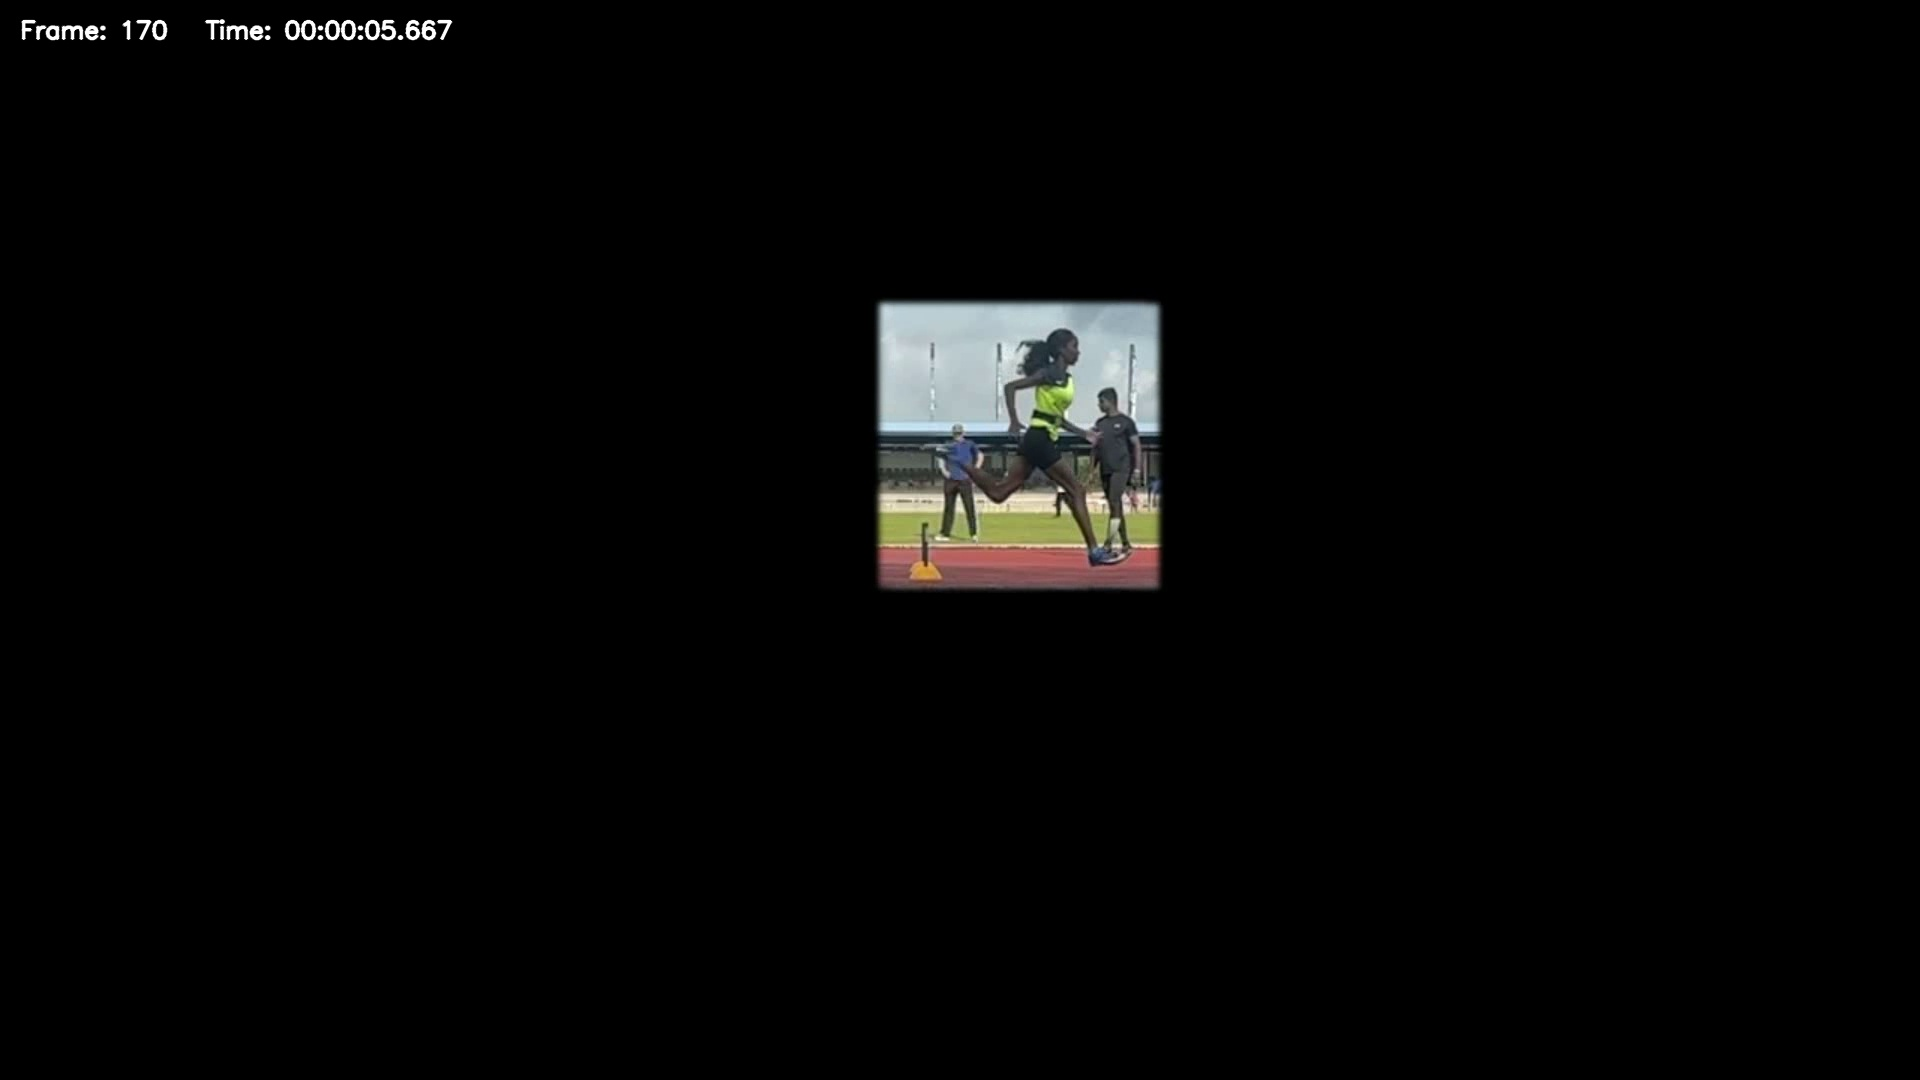

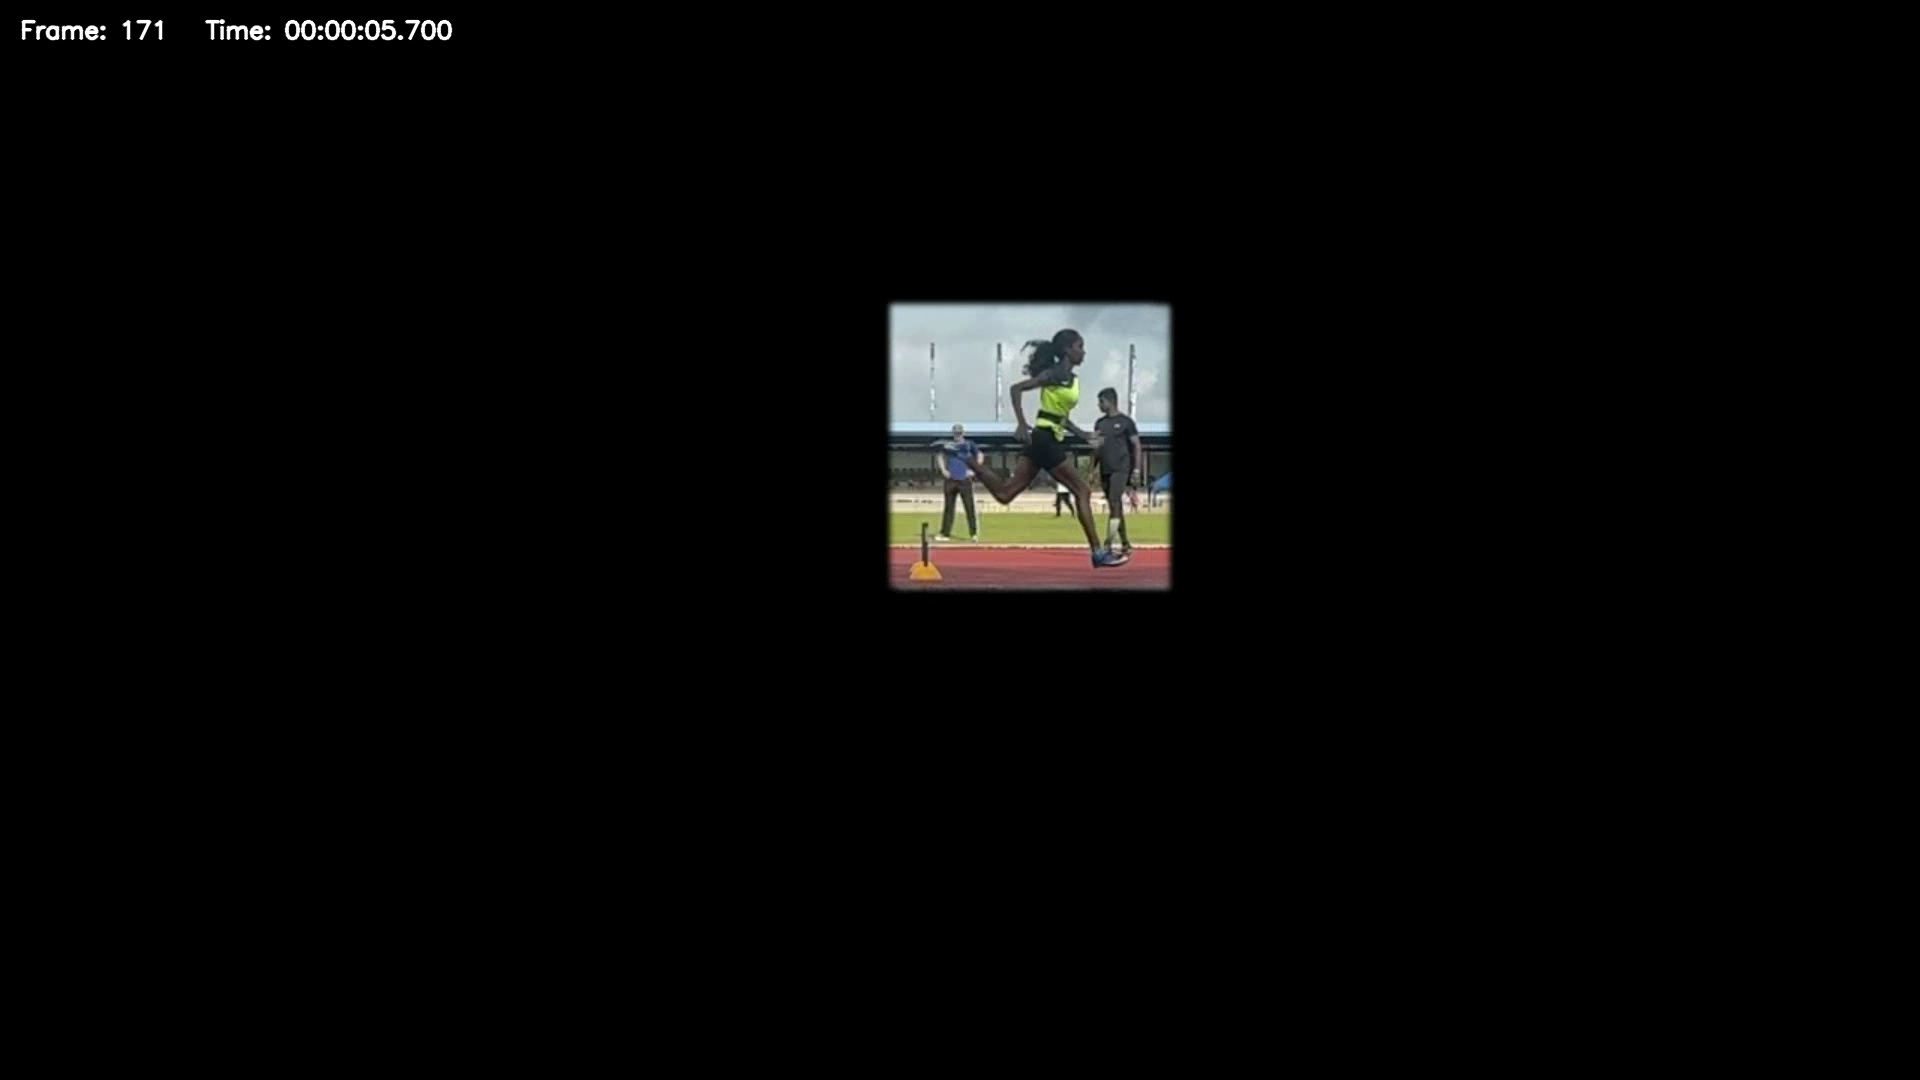

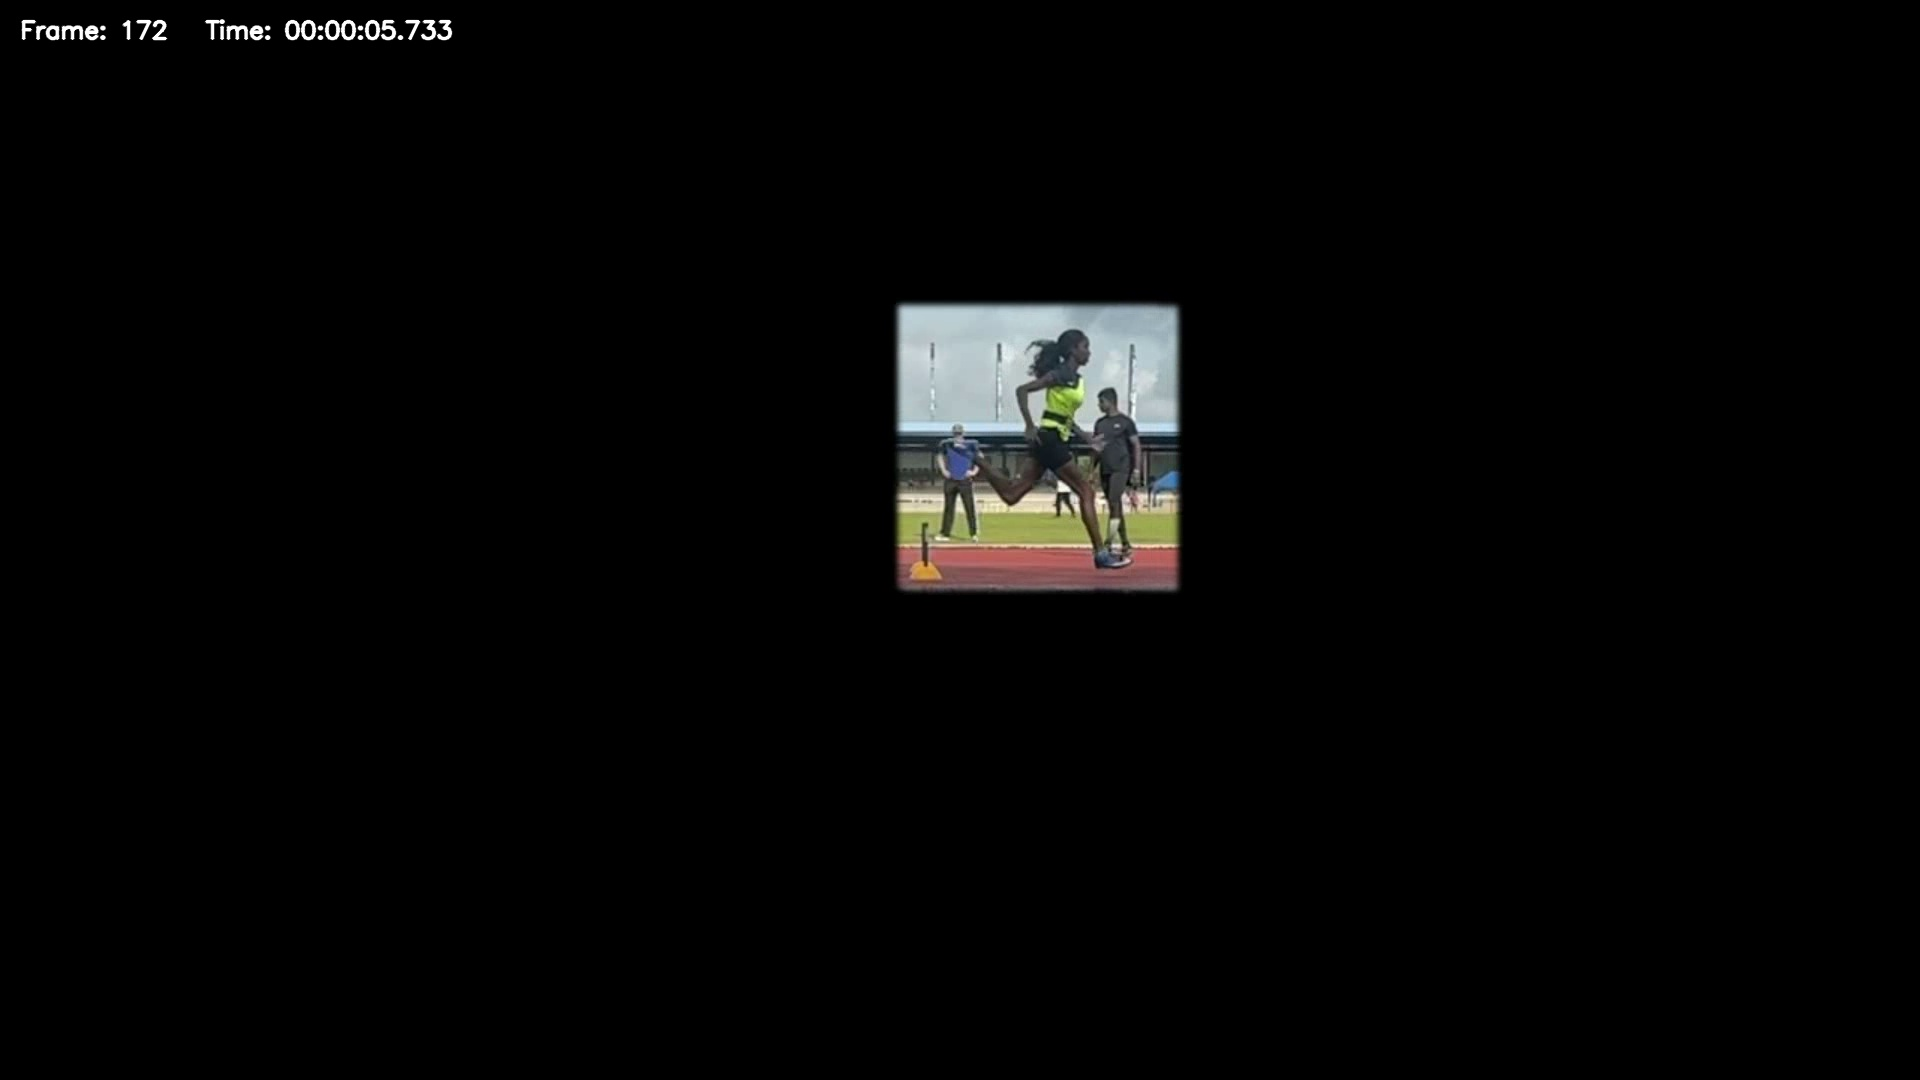

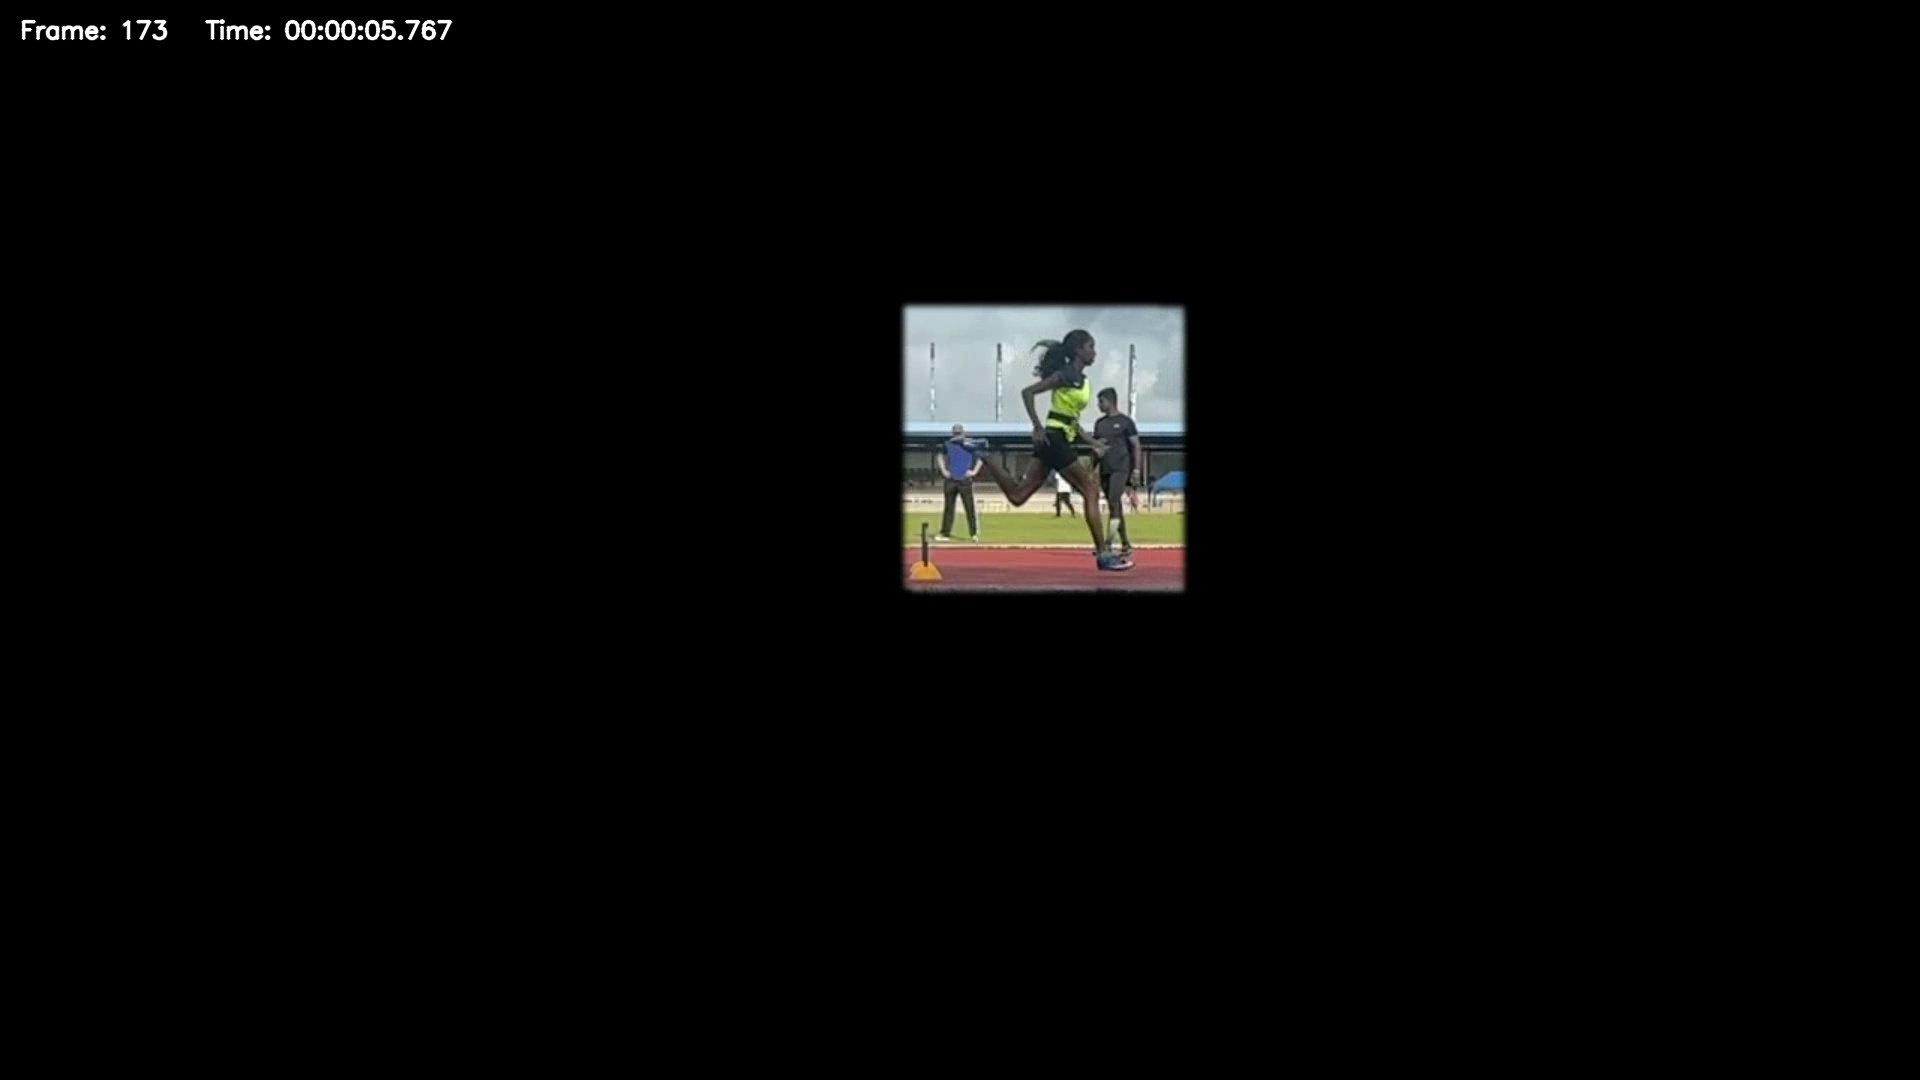

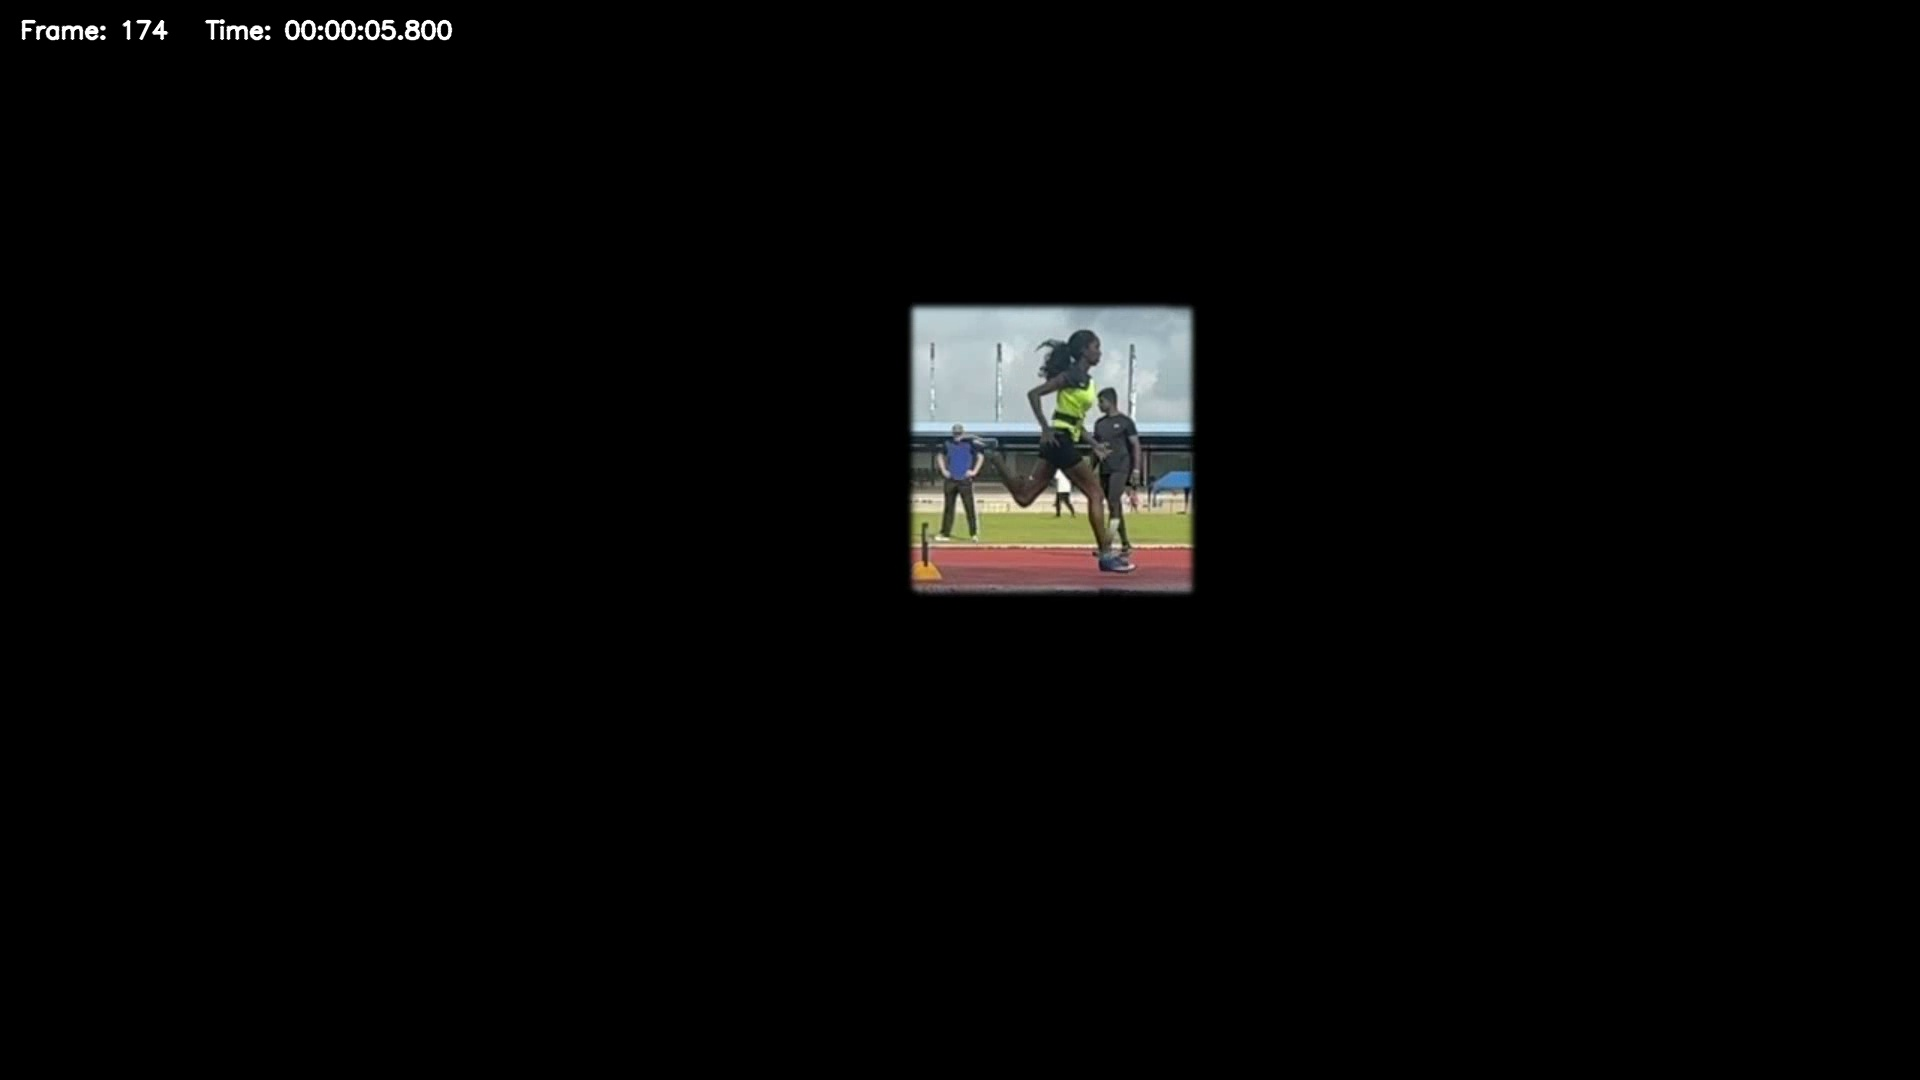

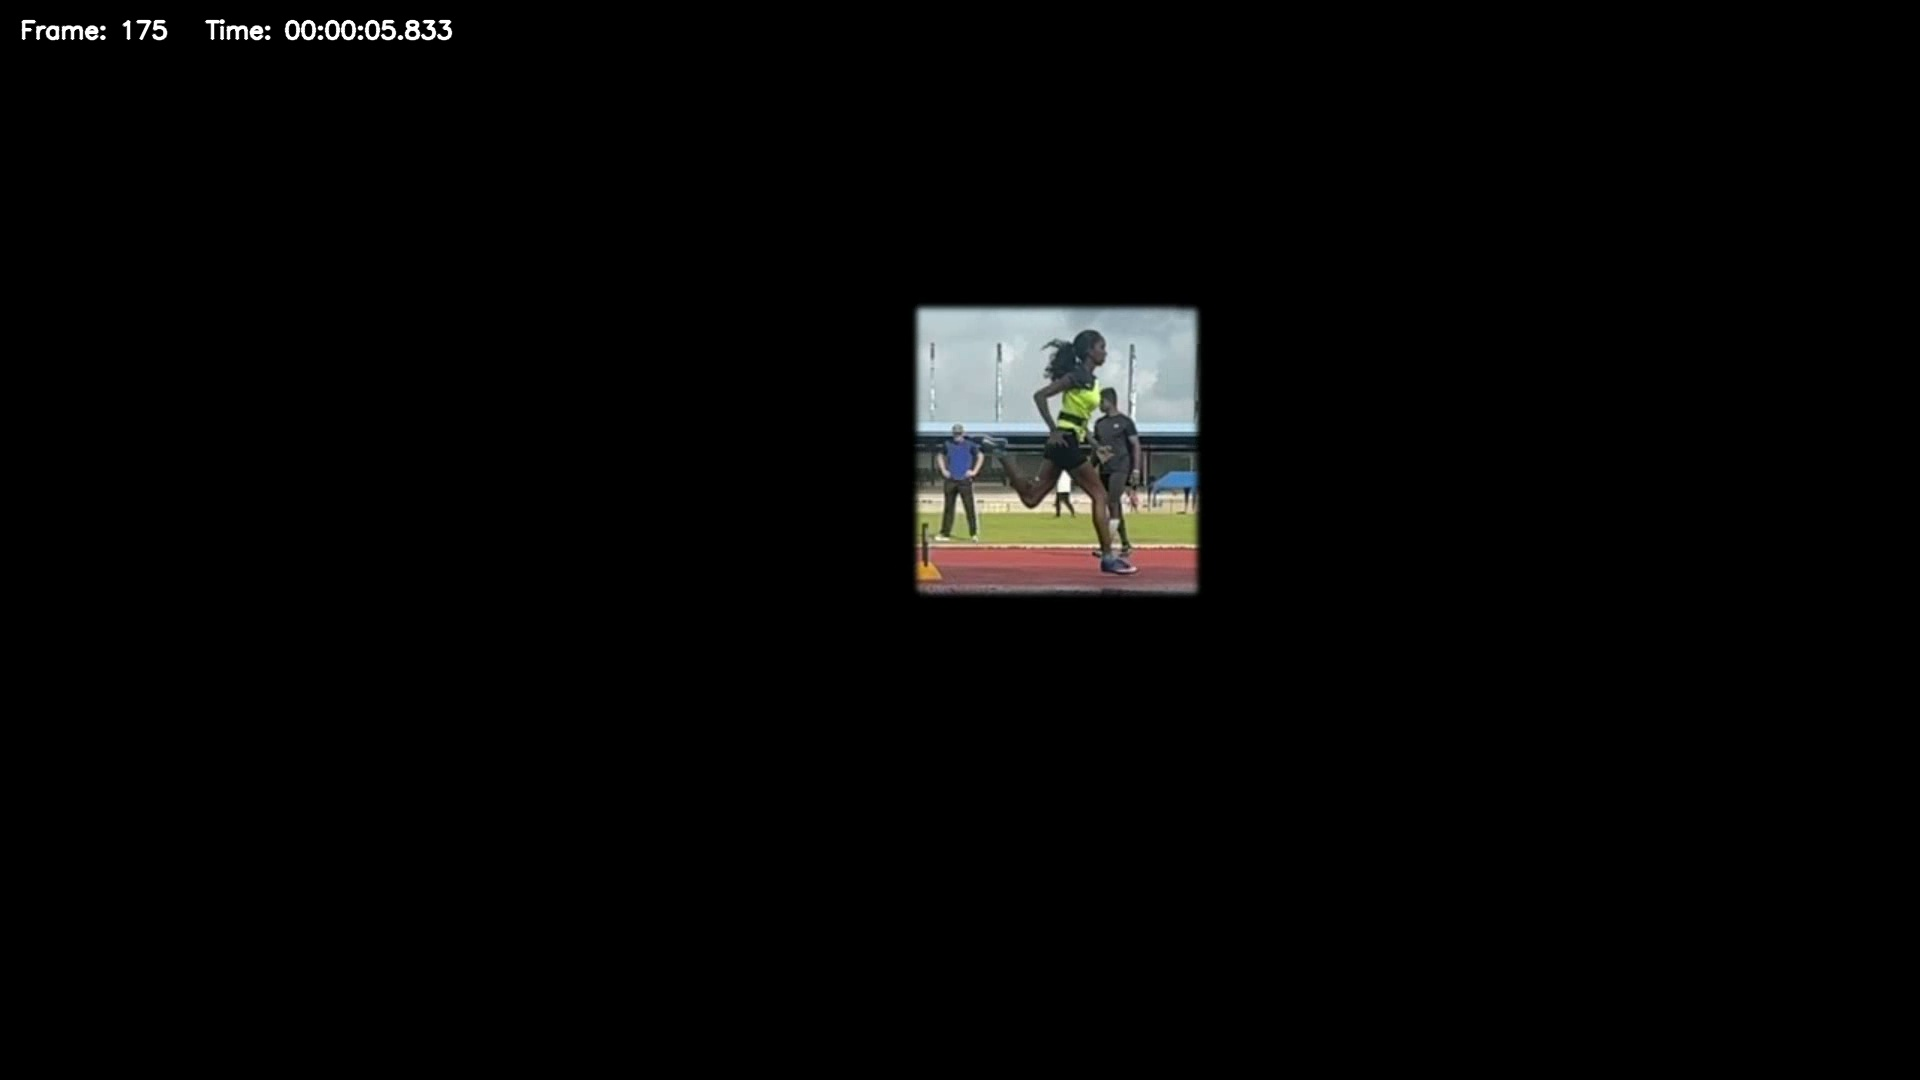

In [3]:
# %% [markdown]
# ## Export chosen frame range
# - Set START_FRAME and END_FRAME (inclusive)
# - Each saved image includes the frame number and timestamp
# - Optionally includes the pose skeleton if DO_ANNOTATE=True

# %%
START_FRAME = 170
END_FRAME   = 180  # inclusive

START_FRAME = max(0, START_FRAME)
END_FRAME = min(FRAME_COUNT - 1, END_FRAME)
if END_FRAME < START_FRAME:
    raise ValueError("END_FRAME must be >= START_FRAME")

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

saved_records = []  # reset/collect for CSV

with mp_pose.Pose(
    static_image_mode=False,
    model_complexity=MODEL_COMPLEXITY,
    enable_segmentation=False,
    min_detection_confidence=MIN_DET,
    min_tracking_confidence=MIN_TRK
) as pose:

    for fidx in tqdm(range(START_FRAME, END_FRAME + 1), desc="Exporting frames"):
        # Random access (may be approximate depending on codec)
        cap.set(cv2.CAP_PROP_POS_FRAMES, fidx)
        ok, frame = cap.read()
        if not ok:
            print(f"[WARN] Could not read frame {fidx}, skipping.")
            continue

        out_img = frame.copy()

        if DO_ANNOTATE:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            res = pose.process(frame_rgb)
            if res.pose_landmarks:
                mp_drawing.draw_landmarks(
                    out_img,
                    res.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_styles.get_default_pose_landmarks_style()
                )

        # Label (frame number + timestamp)
        timecode = fmt_timecode(fidx, FPS)
        label = f"Frame: {fidx}   Time: {timecode}"
        (tw, th), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
        pad = 10
        cv2.rectangle(out_img, (10, 10), (10 + tw + 2*pad, 10 + th + 2*pad), (0, 0, 0), -1)
        cv2.putText(out_img, label, (10 + pad, 10 + th + pad),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

        # Save image
        out_path = OUTPUT_DIR / f"frame_{fidx:06d}.jpg"
        cv2.imwrite(str(out_path), out_img)

        saved_records.append({
            "frame": fidx,
            "time_seconds": (fidx / FPS) if FPS > 0 else 0.0,
            "timecode": timecode,
            "image_path": str(out_path.resolve())
        })

cap.release()

print(f"Saved {len(saved_records)} frames to: {OUTPUT_DIR.resolve()}")

# Optional quick inline preview (up to 6)
try:
    from IPython.display import display
    from PIL import Image
    for rec in saved_records[:6]:
        display(Image.open(rec["image_path"]))
except Exception:
    pass
